# 本地ONNX Runtime部署-摄像头实时预测

同济子豪兄 2023-7-18

## 本代码需在终端本地运行

## 导入工具包

In [1]:
import time
import numpy as np
import cv2

import onnxruntime

import matplotlib.pyplot as plt
%matplotlib inline

## 载入 ONNX 模型，获取 ONNX Runtime 推理器

In [2]:
# ONNX 模型路径
onnx_path = 'mmseg2onnx_fastscnn/end2end.onnx'

In [3]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names))


## 可视化配置

In [4]:
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [5]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

## 逐帧处理函数

In [6]:
opacity = 0.3 # 透明度，越大越接近原图

In [7]:
def process_frame(img_bgr):
    
    '''
    输入摄像头画面 bgr-array，输出图像 bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    # 从原图中裁剪出高宽比1:2的最大图像
    h, w = img_bgr.shape[0], img_bgr.shape[1]
    new_h = w // 2 # 横屏图片，截取一半的宽度，作为新的高度
    img_bgr_crop = img_bgr[0:new_h, :]
    
    # 缩放至模型要求的高1024 x 宽2048像素
    img_bgr_resize = cv2.resize(img_bgr_crop, (2048, 1024)) # 缩放尺寸
    
    # 预处理
    img_tensor = img_bgr_resize
    mean = (123.675, 116.28, 103.53) # BGR 三通道的均值
    std = (58.395, 57.12, 57.375) # BGR 三通道的标准差

    # 归一化
    img_tensor = (img_tensor - mean) / std
    img_tensor = img_tensor.astype('float32')
    img_tensor = cv2.cvtColor(img_tensor, cv2.COLOR_BGR2RGB) # BGR 转 RGB
    img_tensor = np.transpose(img_tensor, (2, 0, 1)) # 调整维度
    input_tensor = np.expand_dims(img_tensor, axis=0) # 扩充 batch-size 维度

    # ONNX Runtime预测
    # ONNX Runtime 输入
    ort_inputs = {'input': input_tensor}
    # onnx runtime 输出
    ort_output = ort_session.run(['output'], ort_inputs)[0]
    pred_mask = ort_output[0][0]

    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')

    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)
    
    img_bgr = pred_viz
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    scaler = 2 # 文字大小
    FPS_string = 'FPS {:.2f}'.format(FPS) # 写在画面上的字符串
    img_bgr = cv2.putText(img_bgr, FPS_string, (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)
    
    return img_bgr

## 摄像头拍摄单帧画面

In [9]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(1) # 运行本代码后等几秒拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [10]:
frame.shape

(720, 1280, 3)

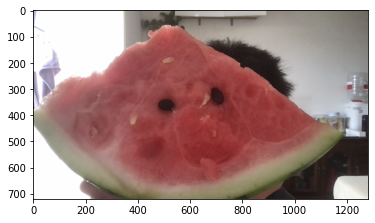

In [22]:
plt.imshow(frame[:,:,::-1])
plt.show()

## 单帧画面语义分割预测

In [12]:
img_bgr = process_frame(frame)

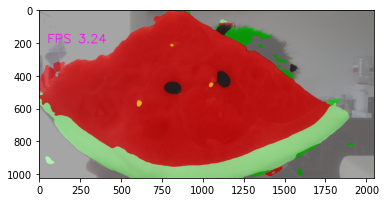

In [24]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 摄像头实时画面逐帧处理（模板）

In [8]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 按`q`键或`Esc`键关闭画面